# Import libraries

In [1]:
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl

In [2]:
# Figure parameters
plt.rcParams["figure.figsize"] = (7,7)

font = {'size'   : 14}

mpl.rc('font', **font)

# Define functions

In [3]:
def change_cmap_bkg_to_white(colormap, n=256):
    """The lowest value of colormaps is not often white by default, which can help idenfity empty bins.
    This function will make the lowest value (typically zero) white."""
    
    tmp_colors = cm.get_cmap(colormap, n)
    newcolors = tmp_colors(np.linspace(0, 1, n))
    white = np.array([1, 1, 1, 1])    # White background (Red, Green, Blue, Alpha).
    newcolors[0, :] = white    # Only change bins with 0 entries.
    newcmp = colors.ListedColormap(newcolors)
    
    return newcmp

def my_hist2d(eff_hist, xedges, yedges, ax, cmap=None, colorbar=False):
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = eff_hist.T.ravel()
  cmap = change_cmap_bkg_to_white(cmap)
  h, edges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=0.0, vmax=1.05)
  if colorbar:
    cb = plt.colorbar(image, ax=ax)#, norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),extend='both')
  return h, edges, yedges, image

z_ME2 = 808 # cm

def calcStar(eta_gen, phi_gen, vx, vy, vz):
    """Calculate etastar and phistar for a gen particle."""
    
    r = (z_ME2 - abs(vz))/abs(np.sinh(eta_gen))
    xStar = vx + r * np.cos(phi_gen)
    yStar = vy + r * np.sin(phi_gen)
    rStar = np.sqrt(xStar*xStar + yStar*yStar)
    
    etaStar_gen = np.arcsinh(z_ME2/rStar) * (eta_gen/abs(eta_gen))

    phiStar_gen = []
    for i,evt in enumerate(phi_gen):
        temp = evt.copy()
        temp = np.where(xStar[i] >= 0, np.arctan(yStar[i]/xStar[i]), temp)
        temp = np.where(np.logical_and(xStar[i] < 0, yStar[i] >= 0), np.pi + np.arctan(yStar[i]/xStar[i]), temp)
        temp = np.where(np.logical_and(xStar[i] < 0, yStar[i] < 0), np.arctan(yStar[i]/xStar[i]) - np.pi, temp)
        phiStar_gen.append(temp)
    phiStar_gen = awkward.fromiter(phiStar_gen)    
    
    return etaStar_gen, phiStar_gen

def global_pt(local_pt):
    """Convert BDT-assigned EMTF pT."""
    global_pt = []
    for i,evt in enumerate(local_pt):
        temp = local_pt[i].copy()
        temp = temp*0.5
        global_pt.append(temp)
    return awkward.fromiter(global_pt)

def global_eta(local_eta):
    """Convert BDT-assigned EMTF eta."""
    global_eta = []
    for i,evt in enumerate(local_eta):
        temp = local_eta[i].copy()
        temp = temp*0.010875
        global_eta.append(temp)
    return awkward.fromiter(global_eta)

def global_phi(emu_phi):
    """Convert BDT-assigned EMTF phi."""
    global_phi = []
    for i,evt in enumerate(emu_phi):
        temp = emu_phi[i] / 576 *2*np.pi - np.pi*15/180
        temp = np.where(temp > np.pi, temp-2*np.pi, temp)
        global_phi.append(temp)
    return awkward.fromiter(global_phi)

# Open ROOT files with `uproot`

In [4]:
# filename = "/eos/cms/store/user/eyigitba/emtf/L1Ntuples/Run3/DisplacedMuons/L1Ntuple_HTo2LLTo4Mu_NNv4.root"
displaced_muon_sample = "./L1Ntuple.root"
HtoLLP_sample = "/eos/cms/store/user/eyigitba/emtf/L1Ntuples/Run3/crabOut/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV_pythia8/L1Ntuple_HTo2LLTo4Mu_cmssw_11_0_2_pTUnc_NNv4_noLUT/200703_130444/L1Ntuple_HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV_pythia8_NNv4_noLUT.root"
filename = "/eos/cms/store/user/eyigitba/emtf/L1Ntuples/Run3/DisplacedMuons/L1Ntuple_HTo2LLTo4Mu_NNv4.root"

f_dm = uproot.open(displaced_muon_sample)
# f_LLP = uproot.open(HtoLLP_sample) # Sample with LUT
f_LLP = uproot.open(filename) # Sample w/out LUT

dm_gen_tree  = f_dm['l1GeneratorTree/L1GenTree/Generator']
dm_emu_tree  = f_dm['l1UpgradeEmuTree/L1UpgradeTree/L1Upgrade']
dm_emtf_tree = f_dm['l1UpgradeTfMuonEmuTree/L1UpgradeTfMuonTree/L1UpgradeEmtfMuon']

LLP_gen_tree  = f_LLP['l1GeneratorTree/L1GenTree/Generator']
LLP_emu_tree  = f_LLP['l1UpgradeEmuTree/L1UpgradeTree/L1Upgrade']
LLP_emtf_tree = f_LLP['l1UpgradeTfMuonEmuTree/L1UpgradeTfMuonTree/L1UpgradeEmtfMuon']

# Define (1) gen, (2) emu, and (3) emtf variables

## (1) gen muons

In [5]:
%%time

dm_gen_id      = dm_gen_tree['partId'].array()
dm_id_mask     = np.abs(dm_gen_id) == 13 # Selects only muons in events
dm_gen_parent  = dm_gen_tree['partParent'].array()[dm_id_mask]
dm_gen_eta     = dm_gen_tree['partEta'].array()[dm_id_mask]
dm_gen_phi     = dm_gen_tree['partPhi'].array()[dm_id_mask]
dm_gen_pt      = dm_gen_tree['partPt'].array()[dm_id_mask]
dm_gen_z0      = dm_gen_tree['partVz'].array()[dm_id_mask]
dm_gen_x0      = dm_gen_tree['partVx'].array()[dm_id_mask]
dm_gen_y0      = dm_gen_tree['partVy'].array()[dm_id_mask]
dm_gen_charge  = dm_gen_tree['partCh'].array()[dm_id_mask]
dm_gen_dxy     = np.sqrt(dm_gen_x0**2 + dm_gen_y0**2)
dm_gen_etastar, dm_gen_phistar = calcStar(dm_gen_eta, dm_gen_phi, dm_gen_x0, dm_gen_y0, dm_gen_z0)

LLP_gen_id      = LLP_gen_tree['partId'].array()
LLP_id_mask     = np.abs(LLP_gen_id) == 13 # Selects only muons in events
LLP_gen_parent  = LLP_gen_tree['partParent'].array()
LLP_parent_mask = LLP_gen_parent == 6000113 # Selects muons specifically from LLP
id_parent_mask  = LLP_id_mask & LLP_parent_mask
LLP_gen_eta     = LLP_gen_tree['partEta'].array()[id_parent_mask]
LLP_gen_phi     = LLP_gen_tree['partPhi'].array()[id_parent_mask]
LLP_gen_pt      = LLP_gen_tree['partPt'].array()[id_parent_mask]
LLP_gen_z0      = LLP_gen_tree['partVz'].array()[id_parent_mask]
LLP_gen_x0      = LLP_gen_tree['partVx'].array()[id_parent_mask]
LLP_gen_y0      = LLP_gen_tree['partVy'].array()[id_parent_mask]
LLP_gen_charge  = LLP_gen_tree['partCh'].array()[id_parent_mask]
LLP_gen_dxy     = np.sqrt(LLP_gen_x0**2 + LLP_gen_y0**2)
LLP_gen_etastar, LLP_gen_phistar = calcStar(LLP_gen_eta, LLP_gen_phi, LLP_gen_x0, LLP_gen_y0, LLP_gen_z0)

CPU times: user 17.8 s, sys: 1.51 s, total: 19.3 s
Wall time: 19.1 s


In [6]:
num_dm_events = len(dm_gen_pt)
print(num_dm_events)
num_LLP_events = len(LLP_gen_pt)
print(num_LLP_events)

40000
40000


## (2) L1 muons

In [7]:
dm_emu_qual   = dm_emu_tree['muonQual'].array()
dm_qual_mask  = dm_emu_qual > 11
dm_emu_eta    = dm_emu_tree['muonEta'].array()[dm_qual_mask]
dm_emu_phi    = dm_emu_tree['muonPhi'].array()[dm_qual_mask]
dm_emu_pt_bdt = dm_emu_tree['muonEt'].array()[dm_qual_mask]
dm_emu_pt_nn  = dm_emu_tree['muonEtUnconstrained'].array()[dm_qual_mask]
dm_emu_dxy    = dm_emu_tree['muonDxy'].array()[dm_qual_mask]

LLP_emu_qual   = LLP_emu_tree['muonQual'].array()
LLP_qual_mask  = LLP_emu_qual > 11
LLP_emu_eta    = LLP_emu_tree['muonEta'].array()[LLP_qual_mask]
LLP_emu_phi    = LLP_emu_tree['muonPhi'].array()[LLP_qual_mask]
LLP_emu_pt_bdt = LLP_emu_tree['muonEt'].array()[LLP_qual_mask]
LLP_emu_pt_nn  = LLP_emu_tree['muonEtUnconstrained'].array()[LLP_qual_mask]
LLP_emu_dxy    = LLP_emu_tree['muonDxy'].array()[LLP_qual_mask]

## (3) EMTF muons

In [8]:
dm_emtf_qual          = dm_emtf_tree['tfMuonHwQual'].array()
dm_emtf_qual_mask     = dm_emtf_qual > 11
dm_emtf_pt_bdt        = dm_emtf_tree['tfMuonHwPt'].array()[dm_emtf_qual_mask]
dm_emtf_pt_global_bdt = global_pt(dm_emtf_pt_bdt)
dm_emtf_pt_nn         = dm_emtf_tree['tfMuonHwPtDxy'].array()[dm_emtf_qual_mask]
dm_emtf_eta           = dm_emtf_tree['tfMuonHwEta'].array()[dm_emtf_qual_mask]
dm_emtf_global_eta    = global_eta(dm_emtf_eta)
dm_emtf_phi           = dm_emtf_tree['tfMuonGlobalPhi'].array()[dm_emtf_qual_mask]
dm_emtf_global_phi    = global_phi(dm_emtf_phi)
dm_emtf_dxy           = dm_emtf_tree['tfMuonHwDxy'].array()[dm_emtf_qual_mask]

LLP_emtf_qual          = LLP_emtf_tree['tfMuonHwQual'].array()
LLP_emtf_qual_mask     = LLP_emtf_qual > 11
LLP_emtf_pt_bdt        = LLP_emtf_tree['tfMuonHwPt'].array()[LLP_emtf_qual_mask]
LLP_emtf_pt_global_bdt = global_pt(LLP_emtf_pt_bdt)
LLP_emtf_pt_nn         = LLP_emtf_tree['tfMuonHwPtDxy'].array()[LLP_emtf_qual_mask]
LLP_emtf_eta           = LLP_emtf_tree['tfMuonHwEta'].array()[LLP_emtf_qual_mask]
LLP_emtf_global_eta    = global_eta(LLP_emtf_eta)
LLP_emtf_phi           = LLP_emtf_tree['tfMuonGlobalPhi'].array()[LLP_emtf_qual_mask]
LLP_emtf_global_phi    = global_phi(LLP_emtf_phi)
LLP_emtf_dxy           = LLP_emtf_tree['tfMuonHwDxy'].array()[LLP_emtf_qual_mask]

# Match gen muons to emu muons and emtf muons

## Displaced Muon Gun

In [9]:
# %%time

dm_gen_matched_emu_mask = [] # mask for gen muons (matched to emu)
dm_gen_matched_emtf_mask = [] # mask for gen muons (matched to emtf)
dm_emu_matched_gen_mask = [] # mask for emu muons (matched to gen)
dm_emtf_matched_gen_mask = [] # mask for emtf muons (matched to gen)

# Placeholders for gen values of L1-matched variables
dm_matched_emu_gen_pt = []
dm_matched_emu_gen_etastar = []
dm_matched_emu_gen_phistar = []
dm_matched_emu_gen_dxy = []
dm_matched_emu_gen_z0 = []

# Placeholders for gen values of emu-matched variables
dm_matched_emtf_gen_pt = []
dm_matched_emtf_gen_etastar = []
dm_matched_emtf_gen_phistar = []
dm_matched_emtf_gen_dxy = []
dm_matched_emtf_gen_z0 = []

for evt in range(num_dm_events):
    # COUNTER
    if evt % 10000 == 0:
        print("Processing event",evt)
#     if evt > 10: break

    emu_matched_gen = [] # True if L1 muon is matched, False otherwise
    emtf_matched_gen = [] # True if EMTF muon is matched, False otherwise
    
    num_gen_parts = len(dm_gen_etastar[evt])
    num_emu_parts = len(dm_emu_eta[evt])
    num_emtf_parts = len(dm_emtf_eta[evt])
    
    emu_gen_match = np.repeat(False, len(dm_gen_etastar[evt])) # True if gen muon is matched to L1 muon
    emtf_gen_match = np.repeat(False, len(dm_gen_etastar[evt])) # True if gen muon is matched to EMTF muon
    
    
    for i in range(num_emu_parts):
        ################ Matching to emu muons
        gen_emu_deltaEta = np.repeat(dm_emu_eta[evt][i], num_gen_parts) - dm_gen_etastar[evt] # deltaEta between reco jets and gen b
        gen_emu_deltaPhi = np.repeat(dm_emu_phi[evt][i], num_gen_parts) - dm_gen_phistar[evt] # deltaPhi between reco jets and gen b
        
        # Make sure deltaPhi chooses smaller of two possible deltaPhi options.
        gen_emu_deltaPhi = np.where(gen_emu_deltaPhi > +np.pi, +2*np.pi-gen_emu_deltaPhi, gen_emu_deltaPhi)
        gen_emu_deltaPhi = np.where(gen_emu_deltaPhi < -np.pi, -2*np.pi-gen_emu_deltaPhi, gen_emu_deltaPhi)
        
        gen_emu_deltaR   = np.sqrt(gen_emu_deltaEta**2 + gen_emu_deltaPhi**2) # deltaR between reco jet and gen bs
        
        min_deltaR = np.min(gen_emu_deltaR)
        matched_gen = np.argmin(gen_emu_deltaR)

        if min_deltaR < 0.3 and not emu_gen_match[matched_gen]: # if close and not already matched
            
            emu_matched_gen.append(True)
            emu_gen_match[matched_gen] = True
            
            # assign matching variables
            dm_matched_emu_gen_pt.append(dm_gen_pt[evt][matched_gen])
            dm_matched_emu_gen_etastar.append(dm_gen_etastar[evt][matched_gen])
            dm_matched_emu_gen_phistar.append(dm_gen_phistar[evt][matched_gen])
            dm_matched_emu_gen_dxy.append(dm_gen_dxy[evt][matched_gen])
            dm_matched_emu_gen_z0.append(dm_gen_z0[evt][matched_gen])
        else:
            emu_matched_gen.append(False)
        
        
    for i in range(num_emtf_parts):
        ############### Matching to emtf muons
        gen_emtf_deltaEta = np.repeat(dm_emtf_global_eta[evt][i], num_gen_parts) - dm_gen_etastar[evt] # deltaEta between reco jets and gen b
        gen_emtf_deltaPhi = np.repeat(dm_emtf_global_phi[evt][i], num_gen_parts) - dm_gen_phistar[evt] # deltaPhi between reco jets and gen b
        
        # Make sure deltaPhi chooses smaller of two possible deltaPhi options.
        gen_emtf_deltaPhi = np.where(gen_emtf_deltaPhi > +np.pi, +2*np.pi-gen_emtf_deltaPhi, gen_emtf_deltaPhi)
        gen_emtf_deltaPhi = np.where(gen_emtf_deltaPhi < -np.pi, -2*np.pi-gen_emtf_deltaPhi, gen_emtf_deltaPhi)
        
        gen_emtf_deltaR   = np.sqrt(gen_emtf_deltaEta**2 + gen_emtf_deltaPhi**2) # deltaR between reco jet and gen bs
        
        min_deltaR = np.min(gen_emtf_deltaR)
        matched_gen = np.argmin(gen_emtf_deltaR)
        
        if min_deltaR < 0.3 and not emtf_gen_match[matched_gen]:
            
            emtf_matched_gen.append(True)
            emtf_gen_match[matched_gen] = True

            dm_matched_emtf_gen_pt.append(dm_gen_pt[evt][matched_gen])
            dm_matched_emtf_gen_etastar.append(dm_gen_etastar[evt][matched_gen])
            dm_matched_emtf_gen_phistar.append(dm_gen_phistar[evt][matched_gen])
            dm_matched_emtf_gen_dxy.append(dm_gen_dxy[evt][matched_gen])
            dm_matched_emtf_gen_z0.append(dm_gen_z0[evt][matched_gen])
        else:
            emtf_matched_gen.append(False)
    
    if len(emu_matched_gen) > 0: # avoids appending empty lists
        dm_gen_matched_emu_mask.append(emu_matched_gen)
    if len(emtf_matched_gen) > 0: # avoids appending empty lists
        dm_gen_matched_emtf_mask.append(emtf_matched_gen)
    dm_emu_matched_gen_mask.append(emu_gen_match)
    dm_emtf_matched_gen_mask.append(emtf_gen_match)

print("Loop ended!")
    
dm_gen_matched_emu_mask  = awkward.fromiter(dm_gen_matched_emu_mask)
dm_gen_matched_emtf_mask = awkward.fromiter(dm_gen_matched_emtf_mask)
dm_emu_matched_gen_mask  = awkward.fromiter(dm_emu_matched_gen_mask)
dm_emtf_matched_gen_mask = awkward.fromiter(dm_emtf_matched_gen_mask)


Processing event 0
Processing event 10000
Processing event 20000
Processing event 30000
Loop ended!


In [10]:
# convert from lists to arrays

dm_matched_emu_gen_pt      = np.asarray(dm_matched_emu_gen_pt)
dm_matched_emu_gen_etastar = np.asarray(dm_matched_emu_gen_etastar)
dm_matched_emu_gen_phistar = np.asarray(dm_matched_emu_gen_phistar)
dm_matched_emu_gen_dxy     = np.asarray(dm_matched_emu_gen_dxy)
dm_matched_emu_gen_z0      = np.asarray(dm_matched_emu_gen_z0)

dm_matched_emtf_gen_pt      = np.asarray(dm_matched_emtf_gen_pt)
dm_matched_emtf_gen_etastar = np.asarray(dm_matched_emtf_gen_etastar)
dm_matched_emtf_gen_phistar = np.asarray(dm_matched_emtf_gen_phistar)
dm_matched_emtf_gen_dxy     = np.asarray(dm_matched_emtf_gen_dxy)
dm_matched_emtf_gen_z0      = np.asarray(dm_matched_emtf_gen_z0)

In [11]:
total_gen_to_emu = 0
for i in dm_gen_matched_emu_mask:
    total_gen_to_emu+= np.sum(i)

total_emu_to_gen = 0
for i in dm_emu_matched_gen_mask:
    total_emu_to_gen+= np.sum(i)

assert(total_emu_to_gen == total_gen_to_emu)


total_gen_to_emtf = 0
for i in dm_gen_matched_emtf_mask:
    total_gen_to_emtf+= np.sum(i)

total_emtf_to_gen = 0
for i in dm_emtf_matched_gen_mask:
    total_emtf_to_gen+= np.sum(i)
    
assert(total_gen_to_emtf == total_emtf_to_gen)

## LLP Sample

In [12]:
# %%time

LLP_gen_matched_emu_mask = [] # mask for gen muons (matched to emu)
LLP_gen_matched_emtf_mask = [] # mask for gen muons (matched to emtf)
LLP_emu_matched_gen_mask = [] # mask for emu muons (matched to gen)
LLP_emtf_matched_gen_mask = [] # mask for emtf muons (matched to gen)

LLP_matched_emu_gen_pt = []
LLP_matched_emu_gen_etastar = []
LLP_matched_emu_gen_phistar = []
LLP_matched_emu_gen_dxy = []
LLP_matched_emu_gen_z0 = []

LLP_matched_emtf_gen_pt = []
LLP_matched_emtf_gen_etastar = []
LLP_matched_emtf_gen_phistar = []
LLP_matched_emtf_gen_dxy = []
LLP_matched_emtf_gen_z0 = []

matches = []

for evt in range(num_LLP_events):
    # COUNTER
#     if evt > 10: break
#     print("\n Event number ",evt) 

    emu_matched_gen = []
    emtf_matched_gen = []
    
    emu_gen_match = np.repeat(False, len(LLP_gen_etastar[evt]))
    emtf_gen_match = np.repeat(False, len(LLP_gen_etastar[evt]))
    

    num_gen_parts  = len(LLP_gen_etastar[evt])
    num_emu_parts  = len(LLP_emu_eta[evt])
    num_emtf_parts = len(LLP_emtf_eta[evt])
    
    
    for i in range(num_emu_parts):
        ################ Matching to emu muons
        gen_emu_deltaEta = np.repeat(LLP_emu_eta[evt][i], num_gen_parts) - LLP_gen_etastar[evt] # deltaEta between reco jets and gen b
        gen_emu_deltaPhi = np.repeat(LLP_emu_phi[evt][i], num_gen_parts) - LLP_gen_phistar[evt] # deltaPhi between reco jets and gen b
        
        # Make sure deltaPhi chooses smaller of two possible deltaPhi options.
        gen_emu_deltaPhi = np.where(gen_emu_deltaPhi > +np.pi, +2*np.pi-gen_emu_deltaPhi, gen_emu_deltaPhi)
        gen_emu_deltaPhi = np.where(gen_emu_deltaPhi < -np.pi, -2*np.pi-gen_emu_deltaPhi, gen_emu_deltaPhi)
        
        gen_emu_deltaR   = np.sqrt(gen_emu_deltaEta**2 + gen_emu_deltaPhi**2) # deltaR between reco jet and gen bs
        
        min_deltaR = np.min(gen_emu_deltaR)
        matched_gen = np.argmin(gen_emu_deltaR)

        if min_deltaR < 0.3 and not emu_gen_match[matched_gen]:
            
            emu_matched_gen.append(True)
            emu_gen_match[matched_gen] = True
            
            LLP_matched_emu_gen_pt.append(LLP_gen_pt[evt][matched_gen])
            LLP_matched_emu_gen_etastar.append(LLP_gen_etastar[evt][matched_gen])
            LLP_matched_emu_gen_phistar.append(LLP_gen_phistar[evt][matched_gen])
            LLP_matched_emu_gen_dxy.append(LLP_gen_dxy[evt][matched_gen])
            LLP_matched_emu_gen_z0.append(LLP_gen_z0[evt][matched_gen])
        else:
            emu_matched_gen.append(False)

        
    for i in range(num_emtf_parts):
        ############### Matching to emtf muons
        gen_emtf_deltaEta = np.repeat(LLP_emtf_global_eta[evt][i], num_gen_parts) - LLP_gen_etastar[evt] # deltaEta between reco jets and gen b
        gen_emtf_deltaPhi = np.repeat(LLP_emtf_global_phi[evt][i], num_gen_parts) - LLP_gen_phistar[evt] # deltaPhi between reco jets and gen b
        
        # Make sure deltaPhi chooses smaller of two possible deltaPhi options.
        gen_emtf_deltaPhi = np.where(gen_emtf_deltaPhi > +np.pi, +2*np.pi-gen_emtf_deltaPhi, gen_emtf_deltaPhi)
        gen_emtf_deltaPhi = np.where(gen_emtf_deltaPhi < -np.pi, -2*np.pi-gen_emtf_deltaPhi, gen_emtf_deltaPhi)

        gen_emtf_deltaR   = np.sqrt(gen_emtf_deltaEta**2 + gen_emtf_deltaPhi**2) # deltaR between reco jet and gen bs
    
        min_deltaR = np.min(gen_emtf_deltaR)
        matched_gen = np.argmin(gen_emtf_deltaR)
        

        if min_deltaR < 0.3 and not emtf_gen_match[matched_gen]:
            
            emtf_matched_gen.append(True)
            emtf_gen_match[matched_gen] = True

            LLP_matched_emtf_gen_pt.append(LLP_gen_pt[evt][matched_gen])
            LLP_matched_emtf_gen_etastar.append(LLP_gen_etastar[evt][matched_gen])
            LLP_matched_emtf_gen_phistar.append(LLP_gen_phistar[evt][matched_gen])
            LLP_matched_emtf_gen_dxy.append(LLP_gen_dxy[evt][matched_gen])
            LLP_matched_emtf_gen_z0.append(LLP_gen_z0[evt][matched_gen])
        else:
            emtf_matched_gen.append(False)

        
    if len(emu_matched_gen) > 0:
        LLP_gen_matched_emu_mask.append(emu_matched_gen)
    if len(emtf_matched_gen) > 0:
        LLP_gen_matched_emtf_mask.append(emtf_matched_gen)
    LLP_emu_matched_gen_mask.append(emu_gen_match)
    LLP_emtf_matched_gen_mask.append(emtf_gen_match)
    
    
LLP_gen_matched_emu_mask  = awkward.fromiter(LLP_gen_matched_emu_mask)
LLP_gen_matched_emtf_mask = awkward.fromiter(LLP_gen_matched_emtf_mask)
LLP_emu_matched_gen_mask  = awkward.fromiter(LLP_emu_matched_gen_mask)
LLP_emtf_matched_gen_mask = awkward.fromiter(LLP_emtf_matched_gen_mask)


In [13]:
LLP_matched_emu_gen_pt = np.asarray(LLP_matched_emu_gen_pt)
LLP_matched_emu_gen_etastar = np.asarray(LLP_matched_emu_gen_etastar)
LLP_matched_emu_gen_phistar = np.asarray(LLP_matched_emu_gen_phistar)
LLP_matched_emu_gen_dxy = np.asarray(LLP_matched_emu_gen_dxy)
LLP_matched_emu_gen_z0 = np.asarray(LLP_matched_emu_gen_z0)

LLP_matched_emtf_gen_pt = np.asarray(LLP_matched_emtf_gen_pt)
LLP_matched_emtf_gen_etastar = np.asarray(LLP_matched_emtf_gen_etastar)
LLP_matched_emtf_gen_phistar = np.asarray(LLP_matched_emtf_gen_phistar)
LLP_matched_emtf_gen_dxy = np.asarray(LLP_matched_emtf_gen_dxy)
LLP_matched_emtf_gen_z0 = np.asarray(LLP_matched_emtf_gen_z0)

In [14]:
total_gen_to_emu = 0
for i in LLP_gen_matched_emu_mask:
    total_gen_to_emu+= np.sum(i)

total_emu_to_gen = 0
for i in LLP_emu_matched_gen_mask:
    total_emu_to_gen+= np.sum(i)

assert(total_emu_to_gen == total_gen_to_emu)


total_gen_to_emtf = 0
for i in LLP_gen_matched_emtf_mask:
    total_gen_to_emtf+= np.sum(i)

total_emtf_to_gen = 0
for i in LLP_emtf_matched_gen_mask:
    total_emtf_to_gen+= np.sum(i)
    
assert(total_gen_to_emtf == total_emtf_to_gen)

 # Displaced Muon Sample

## <b>Displaced Muon Gun</b>: Generated Muons

In [15]:
# z0 cut
dm_gen_plus_z0_mask = dm_gen_z0 < 100
dm_gen_minus_z0_mask = dm_gen_z0 > -100
dm_combined_z0_mask = dm_gen_plus_z0_mask & dm_gen_minus_z0_mask

# dxy cut
dm_gen_dxy_mask = dm_gen_dxy < 100
dm_combined_z0_dxy_mask = dm_gen_dxy_mask & dm_combined_z0_mask

# apply mask to gen variables
dm_masked_gen_pt = dm_gen_pt[dm_combined_z0_dxy_mask]
dm_masked_gen_etastar = dm_gen_etastar[dm_combined_z0_dxy_mask]
dm_masked_gen_dxy = dm_gen_dxy[dm_combined_z0_dxy_mask]
dm_masked_gen_z0 = dm_gen_z0[dm_combined_z0_dxy_mask]

CPU times: user 185 ms, sys: 6.87 ms, total: 192 ms
Wall time: 191 ms


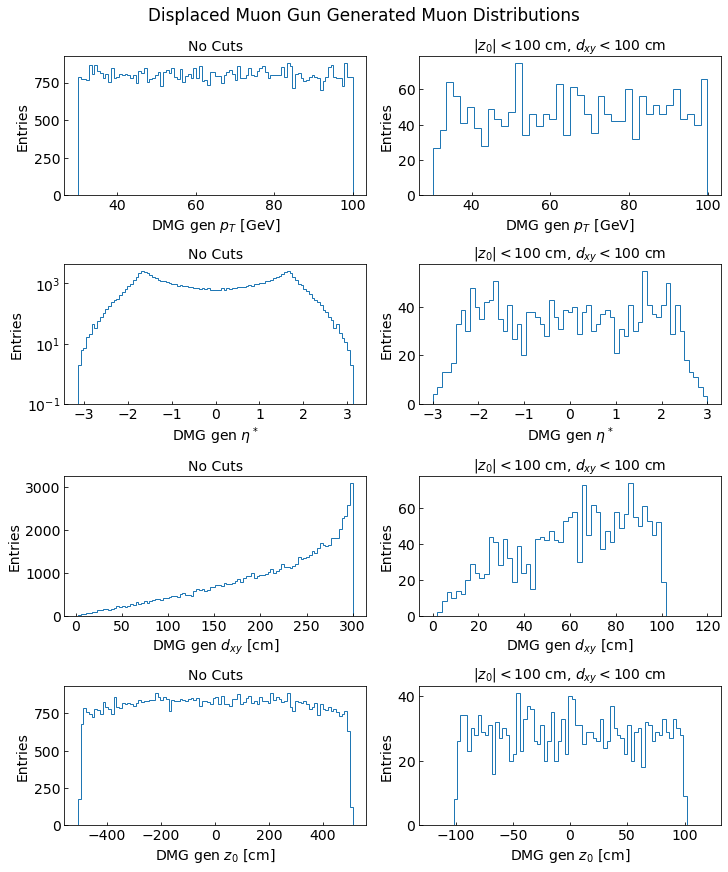

In [16]:
%%time

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun Generated Muon Distributions")

# plot gen pt 
# fig= plt.figure()
ax = axs[0][0]
n, bins, _ = ax.hist(dm_gen_pt.flatten(), bins=100, histtype='step', align='mid')#, log=True)
# n, bins, _ = ax.hist(dm_masked_gen_pt.flatten(), bins=np.linspace(0,100,60), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $p_T$ [GeV]')
ax.tick_params(direction='in')
ax.set_title('No Cuts', fontsize=14)

ax = axs[0][1]
# n, bins, _ = ax.hist(dm_gen_pt.flatten(), bins=100, histtype='step', align='mid')#, log=True)
n, bins, _ = ax.hist(dm_masked_gen_pt.flatten(), bins=40, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $p_T$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm', fontsize=14)


ax = axs[1][0]
n, bins, _ = ax.hist(dm_gen_etastar.flatten(), bins=100, histtype='step', align='mid', log=True)
# n, bins, _ = ax.hist(dm_masked_gen_etastar.flatten(), bins=np.linspace(-3,3,60), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $\eta^*$')
ax.tick_params(direction='in')
ax.set_title('No Cuts', fontsize=14)


ax = axs[1][1]
# n, bins, _ = ax.hist(dm_gen_etastar.flatten(), bins=100, histtype='step', align='mid', log=True)
n, bins, _ = ax.hist(dm_masked_gen_etastar.flatten(), bins=np.linspace(-3,3,60), histtype='step', align='mid')#, label=)#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $\eta^*$')
ax.tick_params(direction='in')
ax.set_title(r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm', fontsize=14)


ax = axs[2][0]
n, bins, _ = ax.hist(dm_gen_dxy.flatten(), bins=100, histtype='step', align='mid')#, log=True)
# n, bins, _ = ax.hist(dm_masked_gen_dxy.flatten(), bins=np.linspace(0,120,60), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title('No Cuts', fontsize=14)


ax = axs[2][1]
# n, bins, _ = ax.hist(dm_gen_dxy.flatten(), bins=100, histtype='step', align='mid')#, log=True)
n, bins, _ = ax.hist(dm_masked_gen_dxy.flatten(), bins=np.linspace(0,120,60), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title(r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm', fontsize=14)



# plot gen z0
# fig= plt.figure()
ax = axs[3][0]
n, bins, _ = ax.hist(dm_gen_z0.flatten(), bins=100, histtype='step', align='mid')#, log=True)
# n, bins, _ = ax.hist(dm_masked_gen_z0.flatten(), bins=np.linspace(-120,120,80), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $z_{0}$ [cm]')
ax.tick_params(direction='in')
ax.set_title('No Cuts', fontsize=14)


ax = axs[3][1]
# n, bins, _ = ax.hist(dm_gen_z0.flatten(), bins=100, histtype='step', align='mid')#, log=True)
n, bins, _ = ax.hist(dm_masked_gen_z0.flatten(), bins=np.linspace(-120,120,80), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'DMG gen $z_{0}$ [cm]')
ax.tick_params(direction='in')
ax.set_title(r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm', fontsize=14)



The generated muons from the displaced muon gun have a flat distribution in $p_T$ from 30 GeV to 100 GeV. There is also a flat distribution in $|z_0|$ from 0 cm to 100 cm.

## Displaced Muon Gun: L1 (GMT) muons

CPU times: user 79.3 ms, sys: 13.7 ms, total: 92.9 ms
Wall time: 84.1 ms


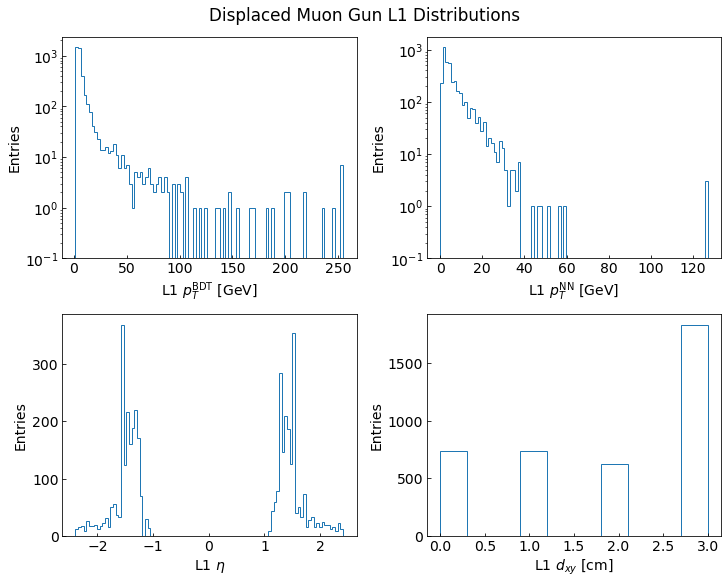

In [17]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun L1 Distributions")

# plot bdt-assigned pT
ax = axs[0][0]
n, bins, _ = ax.hist(dm_emu_pt_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')

# plot nn-assigned pT
ax = axs[0][1]
ax.hist(dm_emu_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')

# plot L1 eta
ax = axs[1][0]
ax.hist(dm_emu_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $\eta$')
ax.tick_params(direction='in')

# plot L1 dxy
ax = axs[1][1]
ax.hist(dm_emu_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $d_{xy}$ [cm]')
ax.tick_params(direction='in')

# Displaced Muon Gun: Making L1 Masks

In [18]:
# Matched values of emu
dm_matched_emu_pt_bdt = dm_emu_pt_bdt.flatten()[dm_gen_matched_emu_mask.flatten()]
dm_matched_emu_pt_nn  = dm_emu_pt_nn.flatten() [dm_gen_matched_emu_mask.flatten()]
dm_matched_emu_eta    = dm_emu_eta.flatten()   [dm_gen_matched_emu_mask.flatten()]
dm_matched_emu_phi    = dm_emu_phi.flatten()   [dm_gen_matched_emu_mask.flatten()]

# Matched values of gen 
dm_matched_gen_dxy    = dm_matched_emu_gen_dxy.flatten()
dm_matched_gen_z0     = dm_matched_emu_gen_z0.flatten()
dm_matched_gen_pt     = dm_matched_emu_gen_pt.flatten()
dm_matched_gen_eta    = dm_matched_emu_gen_etastar.flatten()
dm_matched_gen_phi    = dm_matched_emu_gen_phistar.flatten()

In [19]:
# Masking matched values (masks made using gen values except for assigned pT)
dm_matched_gen_pt_mask     = dm_matched_gen_pt > 20
dm_matched_endcap_mask1    = abs(dm_matched_gen_eta) < 2.4
dm_matched_endcap_mask2    = abs(dm_matched_gen_eta) > 1.24
dm_matched_emu_eta_mask    = dm_matched_endcap_mask1 & dm_matched_endcap_mask2

dm_matched_emu_pt_bdt_mask = dm_matched_emu_pt_bdt > 20
dm_matched_emu_pt_nn_mask  = dm_matched_emu_pt_nn > 20
dm_matched_z0_mask         = abs(dm_matched_gen_z0) < 100
dm_matched_gen_dxy_mask    = dm_matched_gen_dxy < 100
dm_matched_z0_dxy_mask     = dm_matched_gen_dxy_mask & dm_matched_gen_dxy_mask

# Masking all generated muons
dm_gen_pt_mask             = dm_gen_pt > 20
dm_gen_pt_mask             = dm_gen_pt_mask.flatten()
dm_gen_endcap_mask1        = abs(dm_gen_etastar) > 1.24
dm_gen_endcap_mask2        = abs(dm_gen_etastar) < 2.4
dm_gen_endcap_mask         = dm_gen_endcap_mask1 & dm_gen_endcap_mask2
dm_gen_endcap_mask         = dm_gen_endcap_mask.flatten()
dm_gen_z0_mask             = abs(dm_gen_z0) < 100
dm_gen_z0_mask             = dm_gen_z0_mask.flatten()

/usr/local/bin/start_ipykernel.py:15: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/bin/start_ipykernel.py:16: RuntimeWarning: divide by zero encountered in reciprocal


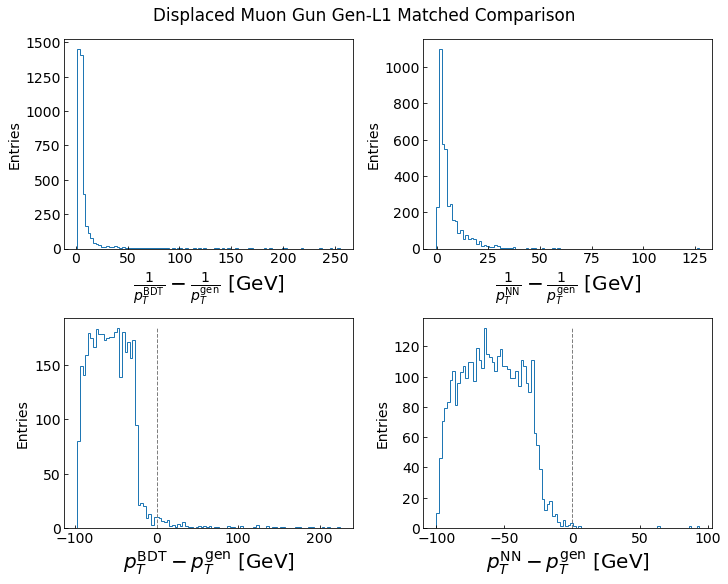

In [20]:
# %%time

# matched values with z0, dxy cuts
# create inverse gen pT for comparison
temp = dm_matched_gen_pt[dm_matched_z0_dxy_mask].copy()
temp = dm_matched_gen_pt.copy()
dm_gen_inv_pt = np.where(temp != 0, np.reciprocal(temp), 0)

# create inverse bdt-pT for comparison
temp = np.reciprocal(dm_matched_emu_pt_bdt.flatten()[dm_matched_z0_dxy_mask].copy())
temp = np.reciprocal(dm_matched_emu_pt_bdt.flatten().copy())
dm_emu_inv_pt_bdt = np.where(temp != 0, np.reciprocal(temp), 0)

# create inverse nn- pT for comparison
temp = np.reciprocal(dm_matched_emu_pt_nn.flatten()[dm_matched_z0_dxy_mask].copy())
temp = np.reciprocal(dm_matched_emu_pt_nn.flatten().copy())
dm_emu_inv_pt_nn = np.where(temp != 0, np.reciprocal(temp), 0)

bdt_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_bdt
nn_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_nn

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun Gen-L1 Matched Comparison")

# plot difference of inverse pT (bdt - true)
ax = axs[0][0]
ax.hist(bdt_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{BDT}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]', fontsize=20)
ax.tick_params(direction='in')


# plot difference of inverse pT (nn - true)
ax = axs[0][1]
ax.hist(nn_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{NN}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]', fontsize=20)

# plot difference (not inverse) of pT
bdt_diff = -dm_matched_gen_pt + dm_matched_emu_pt_bdt.flatten()
nn_diff = -dm_matched_gen_pt + dm_matched_emu_pt_nn.flatten()

# bdt - true 
ax = axs[1][0]
n, bins, _ = ax.hist(bdt_diff.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$p_T^{\mathrm{BDT}} - p_T^{\mathrm{gen}}$ [GeV]', fontsize=20)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

# nn - true
ax = axs[1][1]
n, bins, _ = ax.hist(nn_diff.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$p_T^{\mathrm{NN}} - p_{T}^{\mathrm{gen}}$ [GeV]', fontsize=20)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

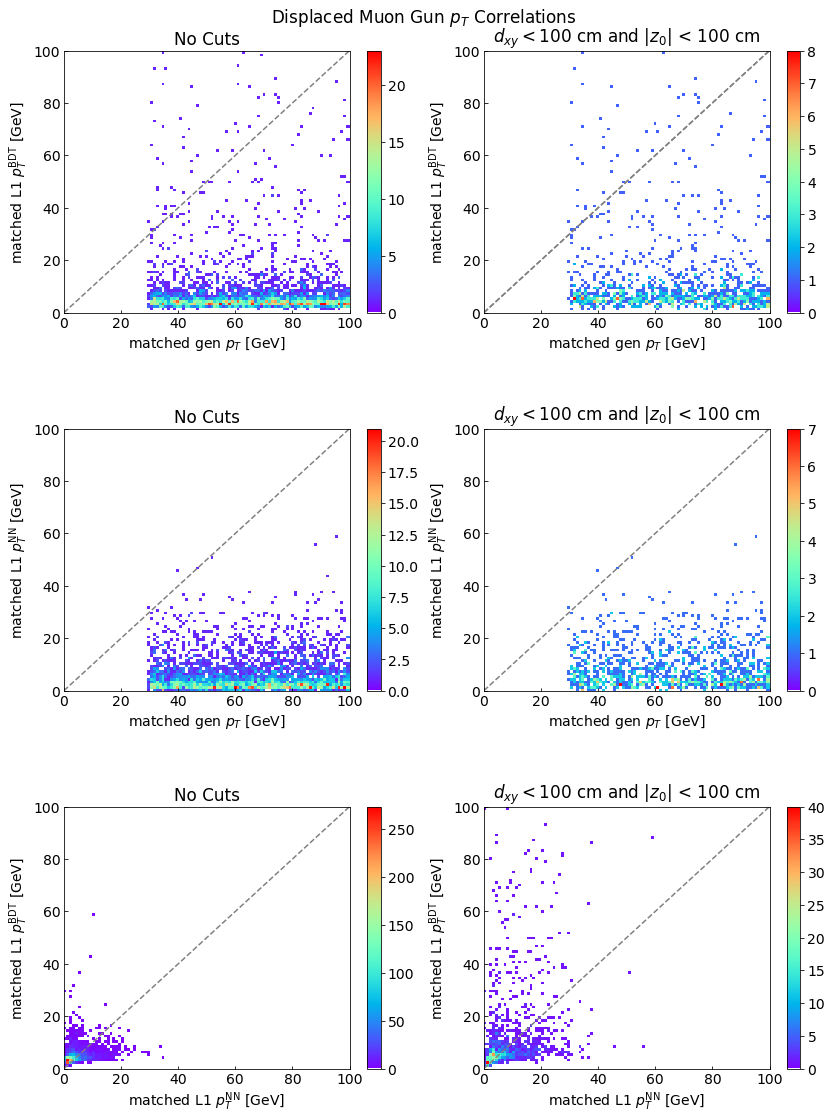

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,16))
fig.subplots_adjust(top=0.3)
fig.suptitle(r"Displaced Muon Gun $p_T$ Correlations", y=0.98)

cmap = change_cmap_bkg_to_white('rainbow')
dm_pt_bins = np.linspace(0, 100, 100)


n, bins, _ = np.histogram2d(dm_matched_gen_pt, dm_matched_emu_pt_bdt.flatten(), bins=(dm_pt_bins, dm_pt_bins))
X, Y = np.meshgrid(dm_pt_bins, dm_pt_bins)

ax = axs[0][0]
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched gen $p_T$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'No Cuts')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')


n, bins, _ = np.histogram2d(dm_matched_gen_pt[dm_matched_z0_dxy_mask], dm_matched_emu_pt_bdt.flatten()[dm_matched_z0_dxy_mask], bins=(dm_pt_bins, dm_pt_bins))
X, Y = np.meshgrid(dm_pt_bins, dm_pt_bins)

ax = axs[0][1]
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched gen $p_T$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'$d_{xy} < 100$ cm and $|z_0|$ < 100 cm')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')


n, bins, _ = np.histogram2d(dm_matched_gen_pt, dm_matched_emu_pt_nn.flatten(), bins=(dm_pt_bins, dm_pt_bins))
X, Y = np.meshgrid(dm_pt_bins, dm_pt_bins)

ax = axs[1][0]
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched gen $p_T$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'No Cuts')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')

n, bins, _ = np.histogram2d(dm_matched_gen_pt[dm_matched_z0_dxy_mask], dm_matched_emu_pt_nn.flatten()[dm_matched_z0_dxy_mask], bins=(dm_pt_bins, dm_pt_bins))
X, Y = np.meshgrid(dm_pt_bins, dm_pt_bins)

ax = axs[1][1]
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched gen $p_T$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'$d_{xy} < 100$ cm and $|z_0|$ < 100 cm')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')


n, bins, _ = np.histogram2d(dm_matched_emu_pt_nn.flatten(), dm_matched_emu_pt_bdt.flatten(), bins=(dm_pt_bins, dm_pt_bins))
X, Y = np.meshgrid(dm_pt_bins, dm_pt_bins)

ax = axs[2][0]
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'No Cuts')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')


n, bins, _ = np.histogram2d(dm_matched_emu_pt_nn.flatten()[dm_matched_z0_dxy_mask], dm_matched_emu_pt_bdt.flatten()[dm_matched_z0_dxy_mask], bins=(dm_pt_bins, dm_pt_bins))
X, Y = np.meshgrid(dm_pt_bins, dm_pt_bins)

ax = axs[2][1]
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'$d_{xy} < 100$ cm and $|z_0|$ < 100 cm')
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')

plt.tight_layout()

## Displaced Muons: EMU Performances

In [22]:
ptbins  = np.linspace(30,100,22)
etabins = np.asarray([-2.5,-2.1,-1.6,-1.2,1.2,1.6,2.1,2.5])
dxybins = np.concatenate((np.linspace(0,20,15),np.linspace(20,50,15),np.linspace(50,100,10)))

/usr/local/bin/start_ipykernel.py:69: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:99: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:103: RuntimeWarning: invalid value encountered in true_divide


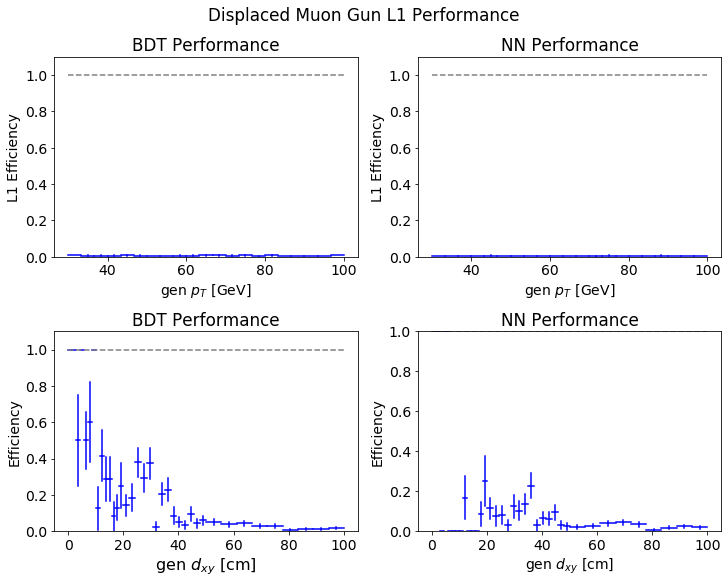

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun L1 Performance")

# PERFORMANCE IN pT

# gen pT of all matched muons in endcap with assigned pT > 20
dm_matched_endcap_ptbdt = dm_matched_emu_eta_mask & dm_matched_emu_pt_bdt_mask.flatten()
numer, bins = np.histogram(dm_matched_gen_pt.flatten()[dm_matched_endcap_ptbdt], bins=ptbins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_pt.flatten()[dm_gen_endcap_mask], bins=ptbins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.logical_or(np.isnan(eff_hist_pt_all), np.isinf(eff_hist_pt_all)), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (ptbins[1:] + ptbins[:-1])/2

ax = axs[0][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([ptbins[i],ptbins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.set_ylabel('L1 Efficiency')
ax.set_title(r'BDT Performance')
ax.plot([ptbins[0],ptbins[-1]], [1.0,1.0], linestyle='dashed', color='grey')


# gen pT of all matched muons in endcap with assigned pT > 20
dm_matched_endcap_ptnn = dm_matched_emu_eta_mask & dm_matched_emu_pt_nn_mask.flatten()
numer, bins = np.histogram(dm_matched_gen_pt.flatten()[dm_matched_endcap_ptnn], bins=ptbins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_pt.flatten()[dm_gen_endcap_mask], bins=ptbins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.logical_or(np.isnan(eff_hist_pt_all), np.isinf(eff_hist_pt_all)), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (ptbins[1:] + ptbins[:-1])/2

ax = axs[0][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([ptbins[i],ptbins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.set_ylabel('L1 Efficiency')
ax.set_title('NN Performance')
ax.plot([ptbins[0],ptbins[-1]], [1.0,1.0], linestyle='dashed', color='grey')


# PERFORMANCE IN dxy

num_mask = dm_matched_emu_pt_bdt_mask & dm_matched_gen_pt_mask & dm_matched_emu_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask 

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'BDT Performance')
ax.set_ylabel('Efficiency')
ax.plot([dxybins[0],dxybins[-1]], [1.0,1.0], linestyle='dashed', color='grey')



num_mask = dm_matched_emu_pt_nn_mask & dm_matched_gen_pt_mask & dm_matched_emu_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.set_title(r'NN Performance')
ax.set_ylabel('Efficiency')
ax.plot([dxybins[0],dxybins[-1]], [1.0,1.0], linestyle='dashed', color='grey')


# num_mask = (dm_matched_emu_pt_nn_mask | dm_matched_emu_pt_bdt_mask) & dm_matched_gen_pt_mask & dm_matched_emu_eta_mask
# denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask


# # gen pT of all matched muons in endcap with assigned pT > 20
# numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# # pT of all muons in endcap
# denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

# eff_hist_pt_all = np.true_divide(numer, denom_all)
# eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
# eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
# eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
# err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

# x = (dxybins[1:] + dxybins[:-1])/2

# ax = axs[1][1]
# for i,w in enumerate(eff_hist_pt_all):
#     ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
#     ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

# # ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
# ax.set_ylim(0.0, 1.0)
# # ax.set_xlim(0.0, 100.0)
# ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
# ax.set_title(r'Efficiency with $|z_0|$ < 100 cm', fontsize=16)
# ax.set_ylabel('Efficiency')

## EMTF Muons

## Displaced Muon Gun: EMTF muons

CPU times: user 141 ms, sys: 6.4 ms, total: 147 ms
Wall time: 139 ms


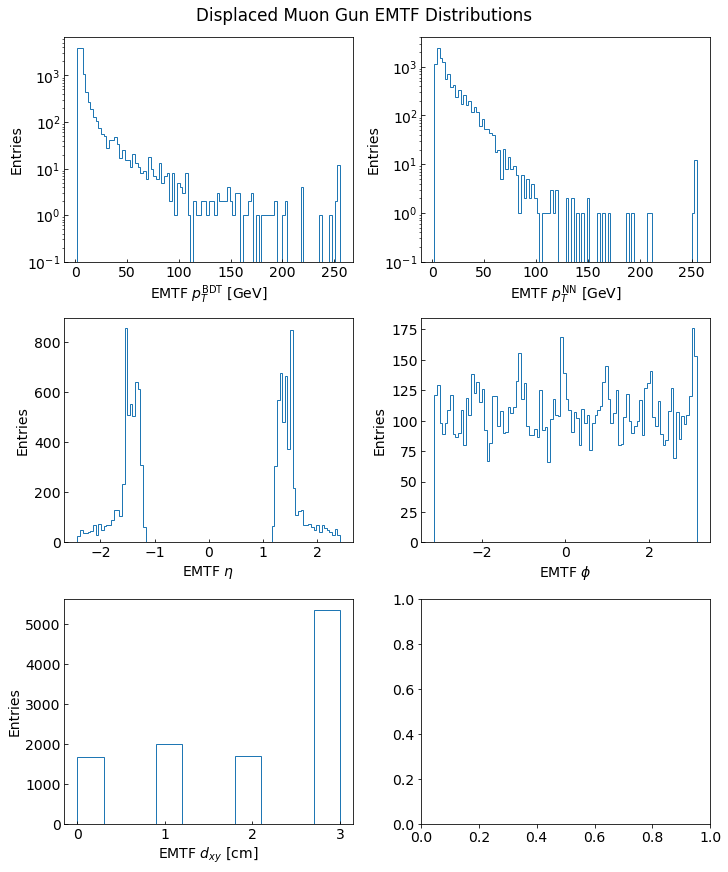

In [45]:
%%time

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun EMTF Distributions")

# fig= plt.figure(figsize=(7,7))
ax = axs[0][0]
ax.hist(dm_emtf_pt_global_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')

# fig= plt.figure(figsize=(7,7))
ax = axs[0][1]
ax.hist(dm_emtf_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')

# fig= plt.figure(figsize=(7,7))
ax = axs[1][0]
ax.hist(dm_emtf_global_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\eta$')
ax.tick_params(direction='in')

# fig= plt.figure(figsize=(7,7))
ax = axs[1][1]
ax.hist(dm_emtf_global_phi.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\phi$')
ax.tick_params(direction='in')

# fig= plt.figure(figsize=(7,7))
ax = axs[2][0]
ax.hist(dm_emtf_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $d_{xy}$ [cm]')
ax.tick_params(direction='in')

In [46]:
# Matched values of emu
dm_matched_emtf_pt_bdt = dm_emtf_pt_bdt.flatten()[dm_gen_matched_emtf_mask.flatten()]
dm_matched_emtf_pt_nn  = dm_emtf_pt_nn.flatten() [dm_gen_matched_emtf_mask.flatten()]
dm_matched_emtf_eta    = dm_emtf_eta.flatten()   [dm_gen_matched_emtf_mask.flatten()]
dm_matched_emtf_phi    = dm_emtf_phi.flatten()   [dm_gen_matched_emtf_mask.flatten()]

# Matched values of gen 
dm_matched_gen_dxy = dm_matched_emtf_gen_dxy.flatten()
dm_matched_gen_z0  = dm_matched_emtf_gen_z0.flatten()
dm_matched_gen_pt  = dm_matched_emtf_gen_pt.flatten()
dm_matched_gen_eta = dm_matched_emtf_gen_etastar.flatten()
dm_matched_gen_phi = dm_matched_emtf_gen_phistar.flatten()

In [47]:
# Masking matched values (masks made using gen values except for assigned pT)
dm_matched_gen_pt_mask     = dm_matched_gen_pt > 20
dm_matched_endcap_mask1    = abs(dm_matched_gen_eta) < 2.4
dm_matched_endcap_mask2    = abs(dm_matched_gen_eta) > 1.24
dm_matched_gen_eta_mask    = dm_matched_endcap_mask1 & dm_matched_endcap_mask2

dm_matched_emtf_pt_bdt_mask = dm_matched_emtf_pt_bdt > 20
dm_matched_emtf_pt_nn_mask  = dm_matched_emtf_pt_nn > 20
dm_matched_z0_mask  = abs(dm_matched_gen_z0) < 100
dm_matched_gen_dxy_mask = dm_matched_gen_dxy < 100
dm_matched_z0_dxy_mask  = dm_matched_gen_dxy_mask & dm_matched_gen_dxy_mask

# Masking all generated muons
dm_gen_pt_mask      = dm_gen_pt > 20
dm_gen_pt_mask      = dm_gen_pt_mask.flatten()
dm_gen_endcap_mask1 = abs(dm_gen_etastar) > 1.24
dm_gen_endcap_mask2 = abs(dm_gen_etastar) < 2.4
dm_gen_endcap_mask  = dm_gen_endcap_mask1 & dm_gen_endcap_mask2
dm_gen_endcap_mask  = dm_gen_endcap_mask.flatten()
dm_gen_z0_mask      = abs(dm_gen_z0) < 100
dm_gen_z0_mask      = dm_gen_z0_mask.flatten()

/usr/local/bin/start_ipykernel.py:9: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/bin/start_ipykernel.py:9: RuntimeWarning: invalid value encountered in reciprocal
/usr/local/bin/start_ipykernel.py:14: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/bin/start_ipykernel.py:14: RuntimeWarning: invalid value encountered in reciprocal


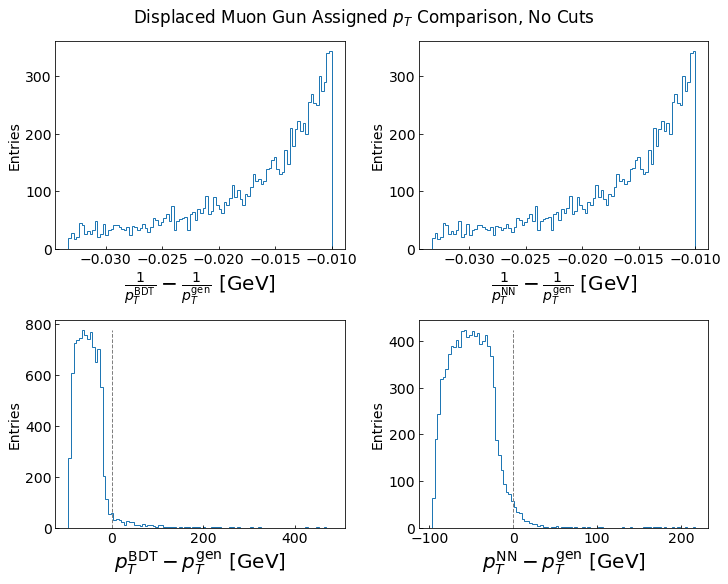

In [48]:
# %%time

# create inverse gen pT for comparison
temp = dm_matched_gen_pt.copy()
dm_gen_inv_pt = np.where(temp != 0, np.reciprocal(temp), 0)

# create inverse bdt-pT for comparison
temp = np.reciprocal(dm_matched_emtf_pt_bdt.flatten().copy())
dm_emu_inv_pt_bdt = np.where(temp != 0, np.reciprocal(temp), 0)


# create inverse nn- pT for comparison
temp = np.reciprocal(dm_matched_emtf_pt_nn.flatten().copy())
dm_emu_inv_pt_nn = np.where(temp != 0, np.reciprocal(temp), 0)

bdt_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_bdt
nn_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_nn

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun Assigned $p_T$ Comparison, No Cuts")

# plot difference of inverse pT (bdt - true)
ax = axs[0][0]
ax.hist(bdt_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{BDT}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]', fontsize=20)
ax.tick_params(direction='in')


# plot difference of inverse pT (nn - true)
ax = axs[0][1]
ax.hist(nn_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{NN}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]', fontsize=20)

# plot difference (not inverse) of pT
bdt_diff = -dm_matched_gen_pt + dm_matched_emtf_pt_bdt.flatten()
nn_diff = -dm_matched_gen_pt + dm_matched_emtf_pt_nn.flatten()



# bdt - true 
ax = axs[1][0]
n, bins, _ = ax.hist(bdt_diff.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$p_T^{\mathrm{BDT}} - p_T^{\mathrm{gen}}$ [GeV]', fontsize=20)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

# nn - true
ax = axs[1][1]
n, bins, _ = ax.hist(nn_diff.flatten(), bins=100, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$p_T^{\mathrm{NN}} - p_{T}^{\mathrm{gen}}$ [GeV]', fontsize=20)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

/usr/local/bin/start_ipykernel.py:10: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/bin/start_ipykernel.py:10: RuntimeWarning: invalid value encountered in reciprocal
/usr/local/bin/start_ipykernel.py:15: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/bin/start_ipykernel.py:15: RuntimeWarning: invalid value encountered in reciprocal


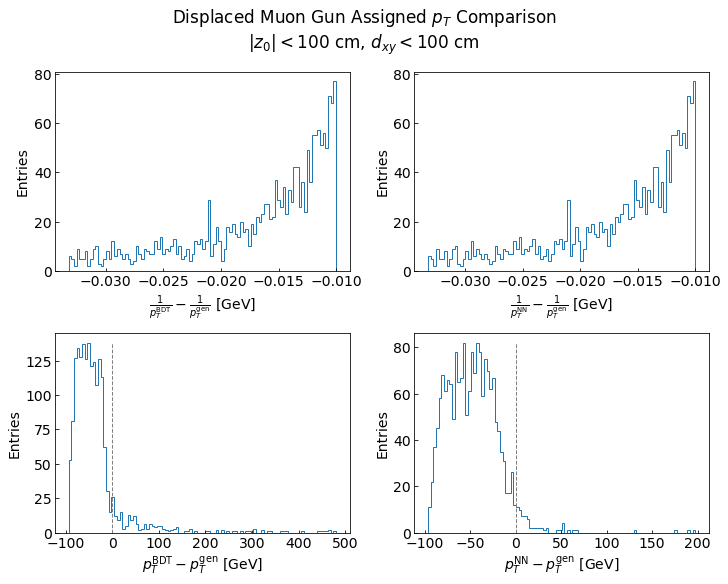

In [49]:
# %%time

# matched values with z0, dxy cuts
# create inverse gen pT for comparison
temp = dm_matched_gen_pt[dm_matched_z0_dxy_mask].copy()
dm_gen_inv_pt = np.where(temp != 0, np.reciprocal(temp), 0)

# create inverse bdt-pT for comparison
temp = np.reciprocal(dm_matched_emtf_pt_bdt.flatten()[dm_matched_z0_dxy_mask].copy())
dm_emu_inv_pt_bdt = np.where(temp != 0, np.reciprocal(temp), 0)


# create inverse nn- pT for comparison
temp = np.reciprocal(dm_matched_emtf_pt_nn.flatten()[dm_matched_z0_dxy_mask].copy())
dm_emu_inv_pt_nn = np.where(temp != 0, np.reciprocal(temp), 0)

bdt_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_bdt
nn_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_nn

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), constrained_layout=True)
fig.suptitle(r"Displaced Muon Gun Assigned $p_T$ Comparison"+'\n'+r"$|z_0| < 100$ cm, $d_{xy} < 100$ cm")

# plot difference of inverse pT (bdt - true)
ax = axs[0][0]
ax.hist(bdt_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid')
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{BDT}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]')
ax.tick_params(direction='in')


# plot difference of inverse pT (nn - true)
# fig = plt.figure(figsize=(7,7))
ax = axs[0][1]
ax.hist(nn_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid')
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{NN}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]')

# plot difference (not inverse) of pT
bdt_diff = -dm_matched_gen_pt[dm_matched_z0_dxy_mask] + dm_matched_emtf_pt_bdt.flatten()[dm_matched_z0_dxy_mask]
nn_diff = -dm_matched_gen_pt[dm_matched_z0_dxy_mask] + dm_matched_emtf_pt_nn.flatten()[dm_matched_z0_dxy_mask]

# bdt - true 
# fig = plt.figure(figsize=(7,7))
ax = axs[1][0]
n, bins, _ = ax.hist(bdt_diff.flatten(), bins=100, histtype='step', align='mid')
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$p_T^{\mathrm{BDT}} - p_T^{\mathrm{gen}}$ [GeV]', fontsize=14)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

# nn - true
# fig = plt.figure(figsize=(7,7))
ax = axs[1][1]
n, bins, _ = ax.hist(nn_diff.flatten(), bins=100, histtype='step', align='mid')
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_xlabel(r'$p_T^{\mathrm{NN}} - p_{T}^{\mathrm{gen}}$ [GeV]')
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

# plt.tight_layout()

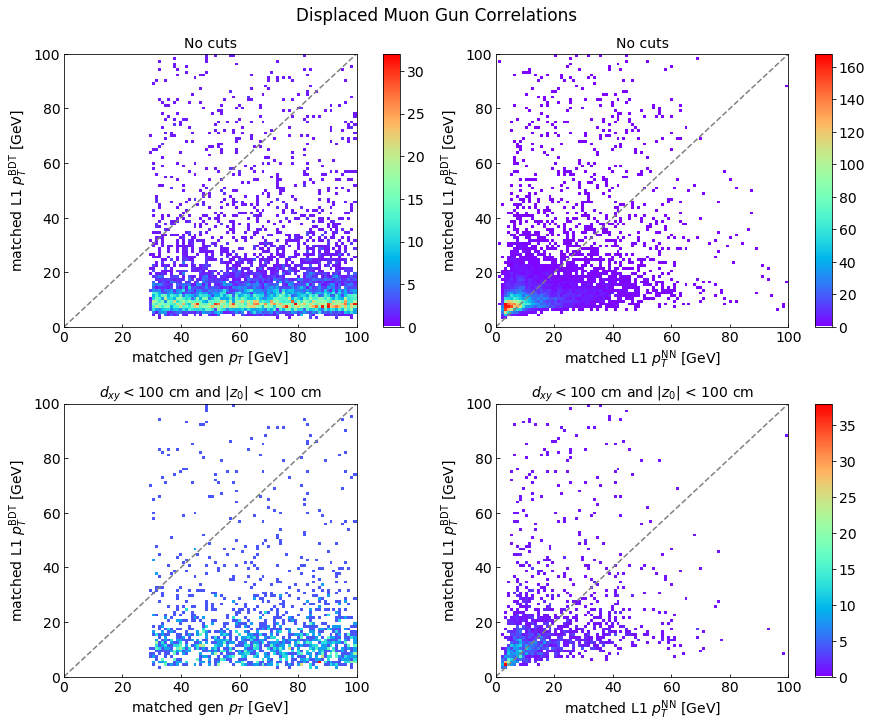

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10), constrained_layout=True)
fig.suptitle('Displaced Muon Gun Correlations')

dm_emtf_bdt_bins = np.linspace(0, 100, 100)
dm_emtf_nn_bins = np.linspace(0, 100, 100)
n, bins, _ = np.histogram2d(dm_matched_gen_pt, dm_matched_emtf_pt_bdt.flatten(), bins=(dm_emtf_bdt_bins, dm_emtf_nn_bins))
X, Y = np.meshgrid(dm_emtf_bdt_bins, dm_emtf_nn_bins)

ax = axs[0][0]
cmap = change_cmap_bkg_to_white('rainbow')
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched gen $p_T$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
# ax.set_title(r'Displaced $\mu$ w/o cuts')
ax.set_title(r'No cuts', fontsize=14)
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')


dm_emtf_bdt_bins = np.linspace(0, 100, 100)
dm_emtf_nn_bins = np.linspace(0, 100, 100)
n, bins, _ = np.histogram2d(dm_matched_emtf_pt_nn.flatten(), dm_matched_emtf_pt_bdt.flatten(), bins=(dm_emtf_bdt_bins, dm_emtf_nn_bins))
X, Y = np.meshgrid(dm_emtf_bdt_bins, dm_emtf_nn_bins)

ax = axs[0][1]
cmap = change_cmap_bkg_to_white('rainbow')
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'No cuts', fontsize=14)
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')

dm_emtf_bdt_bins = np.linspace(0, 100, 100)
dm_emtf_nn_bins = np.linspace(0, 100, 100)
n, bins, _ = np.histogram2d(dm_matched_gen_pt[dm_matched_z0_dxy_mask], dm_matched_emtf_pt_bdt.flatten()[dm_matched_z0_dxy_mask], bins=(dm_emtf_bdt_bins, dm_emtf_nn_bins))
X, Y = np.meshgrid(dm_emtf_bdt_bins, dm_emtf_nn_bins)

ax = axs[1][0]
cmap = change_cmap_bkg_to_white('rainbow')
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)
ax.set_xlabel(r'matched gen $p_T$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'$d_{xy} < 100$ cm and $|z_0|$ < 100 cm', fontsize=14)
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')


dm_emtf_bdt_bins = np.linspace(0, 100, 100)
dm_emtf_nn_bins = np.linspace(0, 100, 100)
n, bins, _ = np.histogram2d(dm_matched_emtf_pt_nn.flatten()[dm_matched_z0_dxy_mask], dm_matched_emtf_pt_bdt.flatten()[dm_matched_z0_dxy_mask], bins=(dm_emtf_bdt_bins, dm_emtf_nn_bins))
X, Y = np.meshgrid(dm_emtf_bdt_bins, dm_emtf_nn_bins)

ax = axs[1][1]
cmap = change_cmap_bkg_to_white('rainbow')
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title(r'$d_{xy} < 100$ cm and $|z_0|$ < 100 cm', fontsize=14)
ax.plot([0,100], [0,100], linestyle='dashed', color='grey')

# plt.tight_layout()

In [51]:
ptbins = np.linspace(30,100,22)
etabins = np.asarray([-2.5,-2.1,-1.6,-1.2,1.2,1.6,2.1,2.5])
dxybins = np.linspace(0,100,100)

0.032825880114176975


Text(0, 0.5, 'Efficiency')

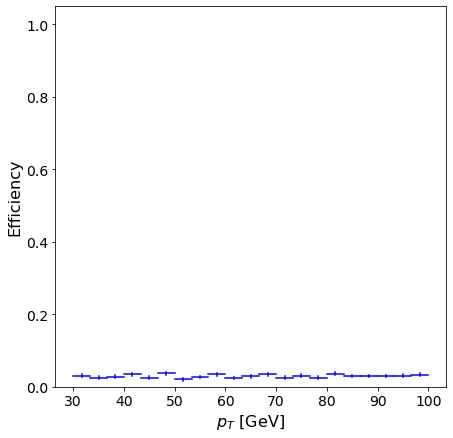

In [52]:
# gen pT of all matched muons in endcap with assigned pT > 20
matched_endcap_ptbdt = dm_matched_gen_eta_mask.flatten() & dm_matched_emtf_pt_bdt_mask
all_matched_gen_pt = dm_matched_gen_pt[matched_endcap_ptbdt]
numer, bins = np.histogram(all_matched_gen_pt, bins=ptbins)

# pT of all muons in endcap
all_gen_pt = dm_gen_pt.flatten()[dm_gen_endcap_mask]
denom_all, bins = np.histogram(all_gen_pt, bins=ptbins)


eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (ptbins[1:] + ptbins[:-1])/2

fig, ax = plt.subplots()
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([ptbins[i],ptbins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.05)
ax.set_xlabel(r'$p_T$ [GeV]', fontsize=16)
ax.set_ylabel('Efficiency', fontsize=16)
# ax.set_title(r'Efficiency for muons with $d_{0} < 700$ cm', fontsize=18)

/usr/local/bin/start_ipykernel.py:11: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:15: RuntimeWarning: invalid value encountered in true_divide


0.18947368421052632


/usr/local/bin/start_ipykernel.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:48: RuntimeWarning: invalid value encountered in true_divide


0.17894736842105263


Text(0, 0.5, 'Efficiency')

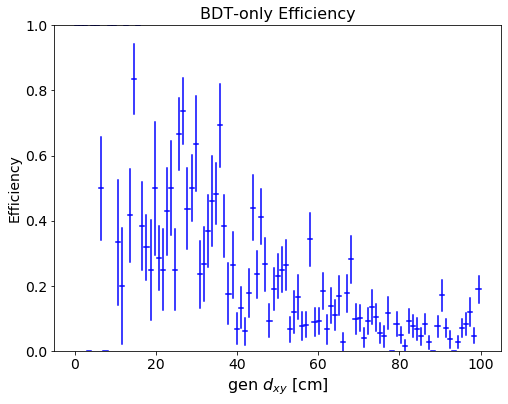

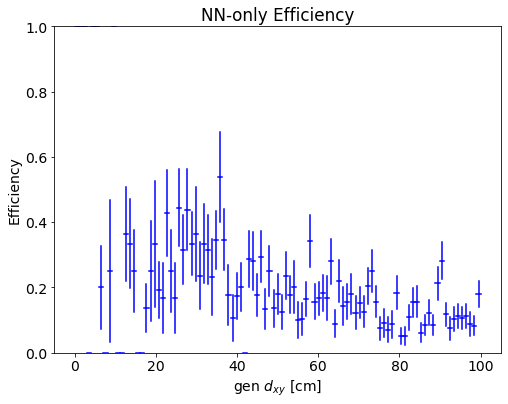

In [53]:
num_mask = dm_matched_emtf_pt_bdt_mask & dm_matched_gen_pt_mask & dm_matched_gen_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)


eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

fig, ax = plt.subplots(figsize=(8,6))
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'BDT-only Efficiency', fontsize=16)
ax.set_ylabel('Efficiency')



num_mask = dm_matched_emtf_pt_nn_mask & dm_matched_gen_pt_mask & dm_matched_gen_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

fig, ax = plt.subplots(figsize=(8,6))
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.set_title(r'NN-only Efficiency')
ax.set_ylabel('Efficiency')

/usr/local/bin/start_ipykernel.py:42: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:77: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:104: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:108: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:124: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


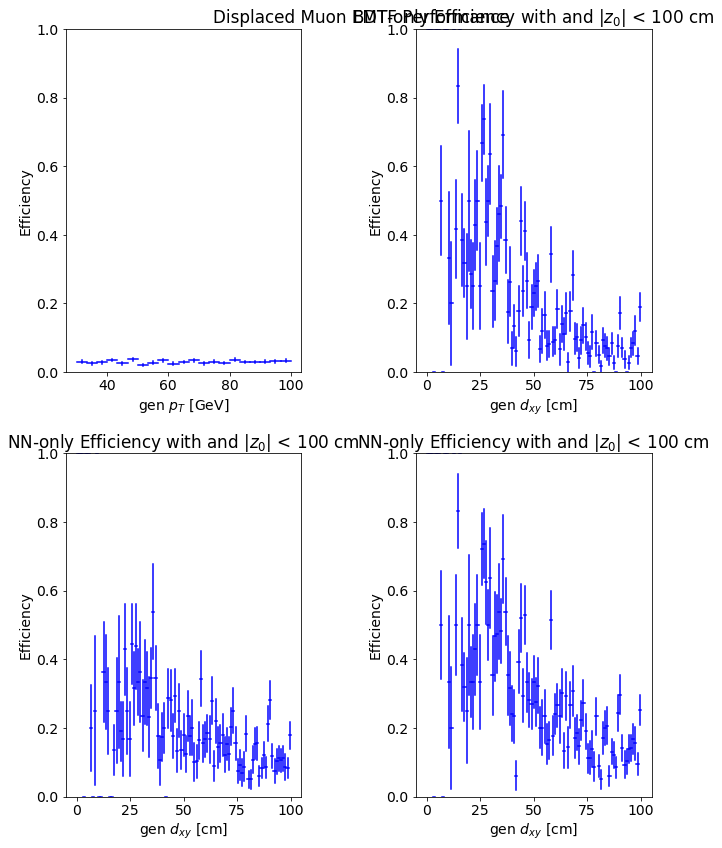

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"Displaced Muon EMTF Performance")


# gen pT of all matched muons in endcap with assigned pT > 20
dm_matched_endcap_ptbdt = dm_matched_gen_eta_mask & dm_matched_emtf_pt_bdt_mask.flatten()
numer, bins = np.histogram(dm_matched_gen_pt.flatten()[dm_matched_endcap_ptbdt], bins=ptbins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_pt.flatten()[dm_gen_endcap_mask], bins=ptbins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (ptbins[1:] + ptbins[:-1])/2

ax = axs[0][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([ptbins[i],ptbins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.set_ylabel('Efficiency')





num_mask = dm_matched_emtf_pt_bdt_mask & dm_matched_gen_pt_mask & dm_matched_gen_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[0][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')


ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.set_title(r'BDT-only Efficiency with and $|z_0|$ < 100 cm')
ax.set_ylabel('Efficiency')




num_mask = dm_matched_emtf_pt_nn_mask & dm_matched_gen_pt_mask & dm_matched_gen_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')


ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.set_title(r'NN-only Efficiency with and $|z_0|$ < 100 cm')
ax.set_ylabel('Efficiency')




num_mask = (dm_matched_emtf_pt_nn_mask | dm_matched_emtf_pt_bdt_mask) & dm_matched_gen_pt_mask & dm_matched_gen_eta_mask
denom_mask = dm_gen_pt_mask & dm_gen_endcap_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(dm_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(dm_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.set_title(r'NN-only Efficiency with and $|z_0|$ < 100 cm')
ax.set_ylabel('Efficiency')

plt.tight_layout()

# Generated LLP Sample

## Generated Muons

CPU times: user 75.1 ms, sys: 16.8 ms, total: 92 ms
Wall time: 76.7 ms


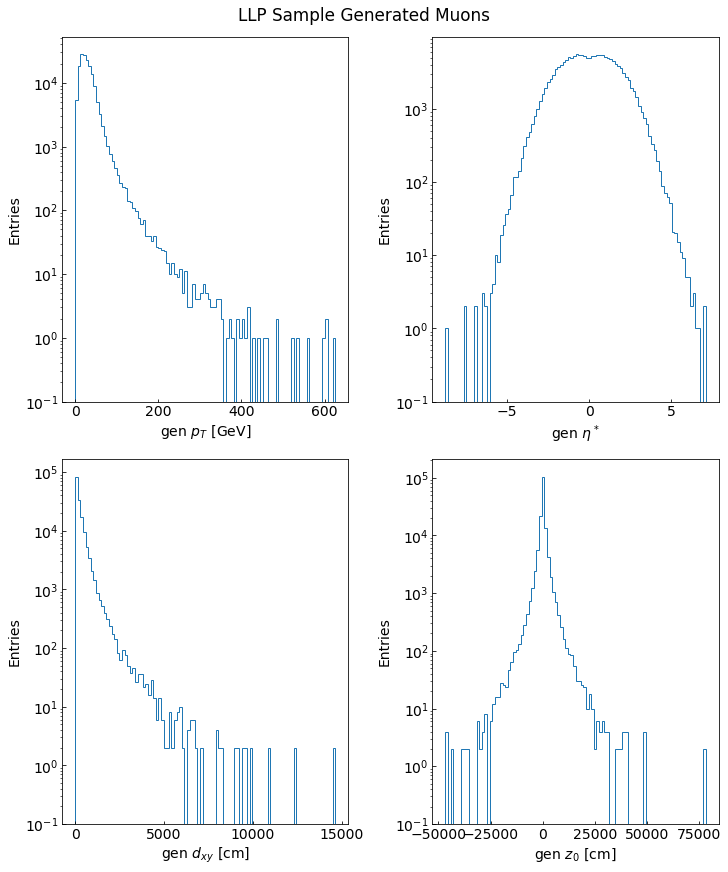

In [33]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"LLP Sample Generated Muons")

ax = axs[0][0]
ax.hist(LLP_gen_pt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.tick_params(direction='in')

ax = axs[0][1]
ax.hist(LLP_gen_etastar.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $\eta^*$')
ax.tick_params(direction='in')
# ax.set_xlim(-3,3)

ax = axs[1][0]
ax.hist(LLP_gen_dxy.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.tick_params(direction='in')

ax = axs[1][1]
ax.hist(LLP_gen_z0.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $z_{0}$ [cm]')
ax.tick_params(direction='in')

## Emulated Muons

CPU times: user 63.5 ms, sys: 25.7 ms, total: 89.2 ms
Wall time: 72.5 ms


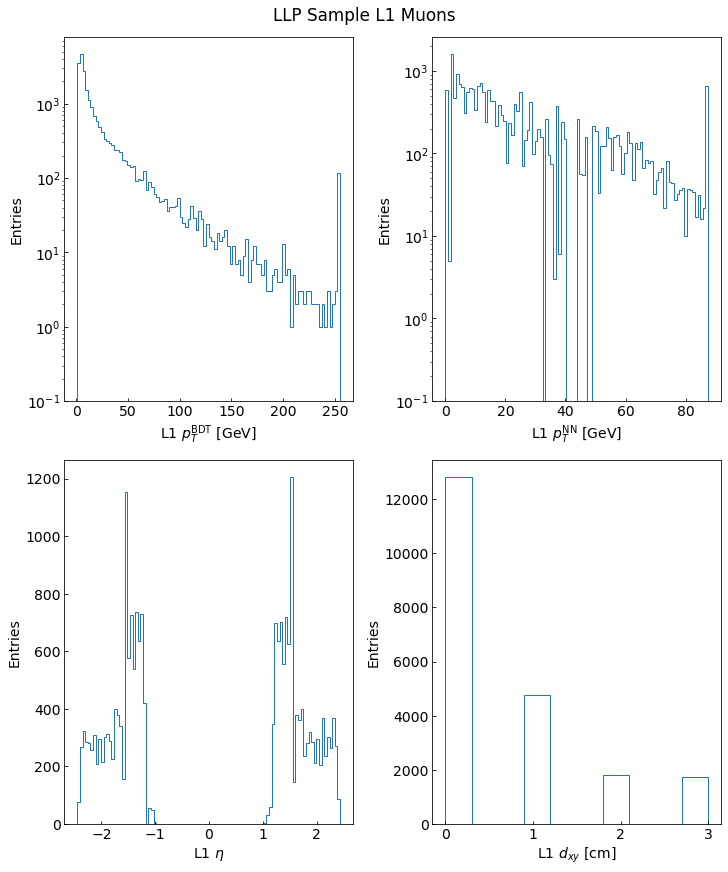

In [34]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"LLP Sample L1 Muons")

ax = axs[0][0]
ax.hist(LLP_emu_pt_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')

ax = axs[0][1]
ax.hist(LLP_emu_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')

ax = axs[1][0]
ax.hist(LLP_emu_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $\eta$')
ax.tick_params(direction='in')

ax = axs[1][1]
ax.hist(LLP_emu_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $d_{xy}$ [cm]')
ax.tick_params(direction='in')

# Making Masks

In [35]:
# Matched values of emu
LLP_matched_emu_pt_bdt = LLP_emu_pt_bdt.flatten()[LLP_gen_matched_emu_mask.flatten()]
LLP_matched_emu_pt_nn  = LLP_emu_pt_nn.flatten() [LLP_gen_matched_emu_mask.flatten()]
LLP_matched_emu_eta    = LLP_emu_eta.flatten()   [LLP_gen_matched_emu_mask.flatten()]
LLP_matched_emu_phi    = LLP_emu_phi.flatten()   [LLP_gen_matched_emu_mask.flatten()]

# Matched values of gen 
LLP_matched_gen_dxy = LLP_matched_emu_gen_dxy
LLP_matched_gen_z0  = LLP_matched_emu_gen_z0
LLP_matched_gen_pt  = LLP_matched_emu_gen_pt
LLP_matched_gen_eta = LLP_matched_emu_gen_etastar
LLP_matched_gen_phi = LLP_matched_emu_gen_phistar

In [36]:
LLP_matched_gen_pt_mask  = LLP_matched_emu_gen_pt > 20
LLP_matched_emu_pt_bdt_mask = LLP_matched_emu_pt_bdt > 20
LLP_matched_emu_pt_nn_mask = LLP_matched_emu_pt_nn > 20
LLP_matched_gen_z0_mask = abs(LLP_matched_gen_z0) < 100
LLP_matched_endcap_mask1 = abs(LLP_matched_gen_eta) < 2.4
LLP_matched_endcap_mask2 = abs(LLP_matched_gen_eta) > 1.24
LLP_matched_emu_eta_mask = LLP_matched_endcap_mask1 & LLP_matched_endcap_mask2

LLP_gen_pt_mask = LLP_gen_pt > 20
LLP_gen_pt_mask = LLP_gen_pt_mask.flatten()
LLP_gen_endcap_mask1 = abs(LLP_gen_etastar) > 1.24
LLP_gen_endcap_mask2 = abs(LLP_gen_etastar) < 2.4
LLP_gen_endcap_mask = LLP_gen_endcap_mask1 & LLP_gen_endcap_mask2
LLP_gen_endcap_mask = LLP_gen_endcap_mask.flatten()
LLP_gen_z0_mask = abs(LLP_gen_z0) < 100
LLP_gen_z0_mask = LLP_gen_z0_mask.flatten()

In [37]:
ptbins = np.concatenate((np.linspace(0,100,22),np.array([150])))
etabins = np.asarray([-2.5,-2.1,-1.6,-1.2,1.2,1.6,2.1,2.5])
dxybins = np.concatenate((np.linspace(0,20,15),np.linspace(20,50,15),np.linspace(50,100,10)))

0.18058690744920994
1.0


/usr/local/bin/start_ipykernel.py:43: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:47: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:77: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:81: RuntimeWarning: invalid value encountered in true_divide


1.0


/usr/local/bin/start_ipykernel.py:107: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:111: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Efficiency')

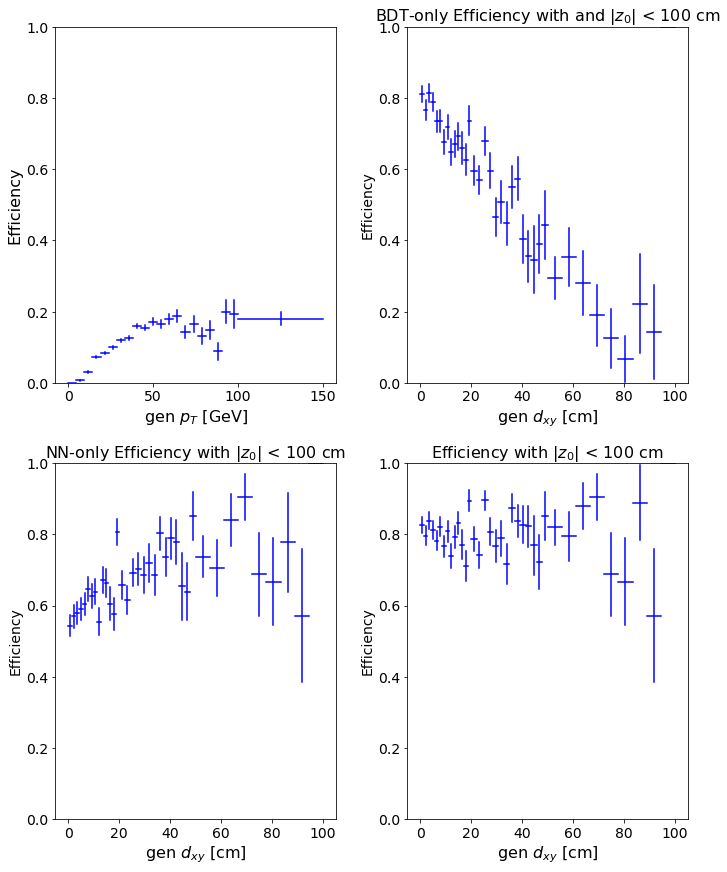

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,12), constrained_layout=True)

# gen pT of all matched muons in endcap with assigned pT > 20
LLP_matched_endcap_ptbdt = LLP_matched_emu_eta_mask & LLP_matched_emu_pt_bdt_mask.flatten()
numer, bins = np.histogram(LLP_matched_gen_pt.flatten()[LLP_matched_endcap_ptbdt], bins=ptbins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_pt.flatten()[LLP_gen_endcap_mask], bins=ptbins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (ptbins[1:] + ptbins[:-1])/2
ax = axs[0][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([ptbins[i],ptbins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $p_T$ [GeV]', fontsize=16)
ax.set_ylabel('Efficiency', fontsize=16)
# ax.set_title(r'Efficiency for muons with $d_{0} < 700$ cm', fontsize=18)





num_mask = LLP_matched_emu_pt_bdt_mask & LLP_matched_gen_z0_mask & LLP_matched_gen_pt_mask & LLP_matched_emu_eta_mask
denom_mask = LLP_gen_pt_mask & LLP_gen_endcap_mask & LLP_gen_z0_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(LLP_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[0][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'BDT-only Efficiency with and $|z_0|$ < 100 cm', fontsize=16)
ax.set_ylabel('Efficiency')




num_mask = LLP_matched_emu_pt_nn_mask & LLP_matched_gen_z0_mask & LLP_matched_gen_pt_mask & LLP_matched_emu_eta_mask
denom_mask = LLP_gen_pt_mask & LLP_gen_endcap_mask & LLP_gen_z0_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(LLP_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')

ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'NN-only Efficiency with $|z_0|$ < 100 cm', fontsize=16)
ax.set_ylabel('Efficiency')




num_mask = (LLP_matched_emu_pt_nn_mask | LLP_matched_emu_pt_bdt_mask) & LLP_matched_gen_z0_mask & LLP_matched_gen_pt_mask & LLP_matched_emu_eta_mask
denom_mask = LLP_gen_pt_mask & LLP_gen_endcap_mask & LLP_gen_z0_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(LLP_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'Efficiency with $|z_0|$ < 100 cm', fontsize=16)
ax.set_ylabel('Efficiency')

# EMTF

## EMTF Muons

CPU times: user 191 ms, sys: 14.5 ms, total: 206 ms
Wall time: 197 ms


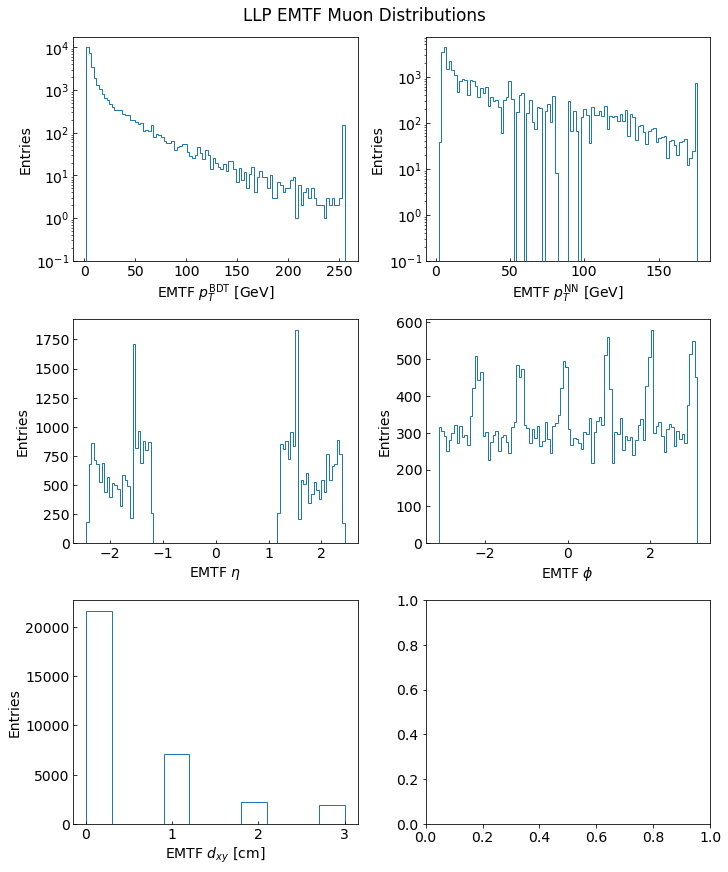

In [39]:
%%time

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"LLP EMTF Muon Distributions")

ax = axs[0][0]
ax.hist(LLP_emtf_pt_global_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')

ax = axs[0][1]
ax.hist(LLP_emtf_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')

ax = axs[1][0]
ax.hist(LLP_emtf_global_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\eta$')
ax.tick_params(direction='in')

ax = axs[1][1]
ax.hist(LLP_emtf_global_phi.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\phi$')
ax.tick_params(direction='in')

ax = axs[2][0]
ax.hist(LLP_emtf_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $d_{xy}$ [cm]')
ax.tick_params(direction='in')

# EMTF Masks

In [40]:
# Matched values of emu
LLP_matched_emtf_pt_bdt = LLP_emtf_pt_bdt.flatten()[LLP_gen_matched_emtf_mask.flatten()]
LLP_matched_emtf_pt_nn  = LLP_emtf_pt_nn.flatten() [LLP_gen_matched_emtf_mask.flatten()]
LLP_matched_emtf_eta    = LLP_emtf_eta.flatten()   [LLP_gen_matched_emtf_mask.flatten()]
LLP_matched_emtf_phi    = LLP_emtf_phi.flatten()   [LLP_gen_matched_emtf_mask.flatten()]

# Matched values of gen 
LLP_matched_gen_dxy = LLP_matched_emtf_gen_dxy
LLP_matched_gen_z0  = LLP_matched_emtf_gen_z0
LLP_matched_gen_pt  = LLP_matched_emtf_gen_pt
LLP_matched_gen_eta = LLP_matched_emtf_gen_etastar
LLP_matched_gen_phi = LLP_matched_emtf_gen_phistar

In [41]:
LLP_matched_gen_pt_mask  = LLP_matched_emtf_gen_pt > 20
LLP_matched_emtf_pt_bdt_mask = LLP_matched_emtf_pt_bdt > 20
LLP_matched_emtf_pt_nn_mask = LLP_matched_emtf_pt_nn > 20
LLP_matched_gen_z0_mask = abs(LLP_matched_gen_z0) < 100
LLP_matched_endcap_mask1 = abs(LLP_matched_gen_eta) < 2.4
LLP_matched_endcap_mask2 = abs(LLP_matched_gen_eta) > 1.24
LLP_matched_emtf_eta_mask = LLP_matched_endcap_mask1 & LLP_matched_endcap_mask2

LLP_gen_pt_mask = LLP_gen_pt > 20
LLP_gen_pt_mask = LLP_gen_pt_mask.flatten()
LLP_gen_endcap_mask1 = abs(LLP_gen_etastar) > 1.24
LLP_gen_endcap_mask2 = abs(LLP_gen_etastar) < 2.4
LLP_gen_endcap_mask = LLP_gen_endcap_mask1 & LLP_gen_endcap_mask2
LLP_gen_endcap_mask = LLP_gen_endcap_mask.flatten()
LLP_gen_z0_mask = abs(LLP_gen_z0) < 100
LLP_gen_z0_mask = LLP_gen_z0_mask.flatten()

In [42]:
ptbins = np.concatenate((np.linspace(0,100,22),np.array([150])))
etabins = np.asarray([-2.5,-2.1,-1.6,-1.2,1.2,1.6,2.1,2.5])
dxybins = np.linspace(0,100,40)

0.19413092550790068
1.0


/usr/local/bin/start_ipykernel.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:83: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:87: RuntimeWarning: invalid value encountered in true_divide


1.0
1.0


/usr/local/bin/start_ipykernel.py:117: RuntimeWarning: invalid value encountered in true_divide
/usr/local/bin/start_ipykernel.py:121: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Efficiency')

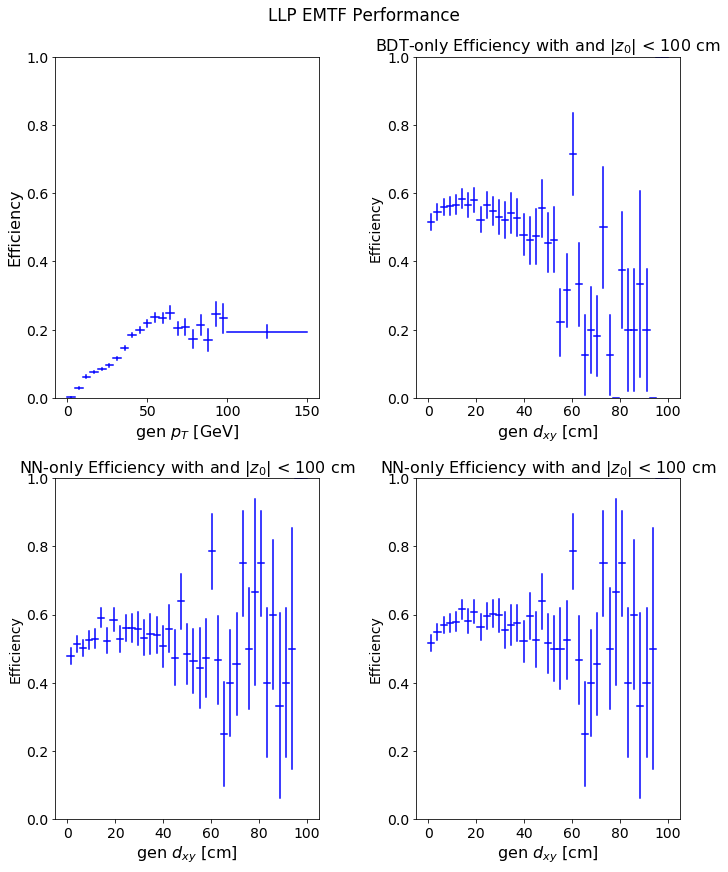

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,12), constrained_layout=True)
fig.suptitle(r"LLP EMTF Performance")


# gen pT of all matched muons in endcap with assigned pT > 20
LLP_matched_endcap_ptbdt = LLP_matched_emtf_eta_mask & LLP_matched_emtf_pt_bdt_mask.flatten()
numer, bins = np.histogram(LLP_matched_gen_pt.flatten()[LLP_matched_endcap_ptbdt], bins=ptbins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_pt.flatten()[LLP_gen_endcap_mask], bins=ptbins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (ptbins[1:] + ptbins[:-1])/2

ax = axs[0][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([ptbins[i],ptbins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r'gen $p_T$ [GeV]', fontsize=16)
ax.set_ylabel('Efficiency', fontsize=16)
# ax.set_title(r'Efficiency for muons with $d_{0} < 700$ cm', fontsize=18)





num_mask = LLP_matched_emtf_pt_bdt_mask & LLP_matched_gen_z0_mask & LLP_matched_gen_pt_mask & LLP_matched_emtf_eta_mask
denom_mask = LLP_gen_pt_mask & LLP_gen_endcap_mask & LLP_gen_z0_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(LLP_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[0][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'BDT-only Efficiency with and $|z_0|$ < 100 cm', fontsize=16)
ax.set_ylabel('Efficiency')
# ax.set_title(r'Efficiency for muons with $d_{0} < 700$ cm', fontsize=18)






num_mask = LLP_matched_emtf_pt_nn_mask & LLP_matched_gen_z0_mask & LLP_matched_gen_pt_mask & LLP_matched_emtf_eta_mask
denom_mask = LLP_gen_pt_mask & LLP_gen_endcap_mask & LLP_gen_z0_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(LLP_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][0]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'NN-only Efficiency with and $|z_0|$ < 100 cm', fontsize=16)
ax.set_ylabel('Efficiency')




num_mask = (LLP_matched_emtf_pt_nn_mask | LLP_matched_emtf_pt_bdt_mask) & LLP_matched_gen_z0_mask & LLP_matched_gen_pt_mask & LLP_matched_emtf_eta_mask
denom_mask = LLP_gen_pt_mask & LLP_gen_endcap_mask & LLP_gen_z0_mask

# gen pT of all matched muons in endcap with assigned pT > 20
numer, bins = np.histogram(LLP_matched_gen_dxy.flatten()[num_mask], bins=dxybins)

# pT of all muons in endcap
denom_all, bins = np.histogram(LLP_gen_dxy.flatten()[denom_mask], bins=dxybins)

eff_hist_pt_all = np.true_divide(numer, denom_all)
eff_hist_pt_all = np.where(np.isnan(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.isinf(eff_hist_pt_all), 0, eff_hist_pt_all)
eff_hist_pt_all = np.where(np.logical_and(np.where(numer==0, True, False), np.where(denom_all == 0, True, False)), 1.0, eff_hist_pt_all)
err = np.sqrt(eff_hist_pt_all*(1-eff_hist_pt_all) / denom_all)

x = (dxybins[1:] + dxybins[:-1])/2

ax = axs[1][1]
for i,w in enumerate(eff_hist_pt_all):
    ax.plot([dxybins[i],dxybins[i+1]], [w,w], color='blue')
    ax.plot([x[i], x[i]], [w-err[i], w+err[i]], color='blue')
    if i == len(eff_hist_pt_all)-1:
        print(w)

# ax.plot([ptbins[0],ptbins[-1]], [0.512,0.512])
ax.set_ylim(0.0, 1.0)
# ax.set_xlim(0.0, 100.0)
ax.set_xlabel(r'gen $d_{xy}$ [cm]', fontsize=16)
ax.set_title(r'NN-only Efficiency with and $|z_0|$ < 100 cm', fontsize=16)
ax.set_ylabel('Efficiency')

plt.tight_layout()